In [168]:
""" 
Importieren von wichtigen Plugins für das System:
- Pandas zur Nutzung von Dataframes als Datentyp zur Speicherung, Veränderung und Anzeige des Datensatzes
- Surprise zur Einbindung als Framework für das Vorschlagssystem inklusive der Algorithmen und Auswertungen
- Der Rest für die Erleichterung der Darstellung und mathematischer Umformungen
"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from surprise import Reader, Dataset, SVD, accuracy
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from statsmodels.stats.outliers_influence import summary_table

In [169]:
"""
Der erste Teil:
- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub
- Datensatz auf gewünschtes Format bringen: Matrix
"""

'\nDer erste Teil:\n- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub\n- Datensatz auf gewünschtes Format bringen: Matrix\n'

In [170]:
"""
Importieren vom Datensatz:
Jeder Eintrag besteht aus: einem User (mit ID), der einem Film (mit ID), ein Rating auf einer Skala von 1-5 (als Float) gibt
"""
ratings = pd.read_csv('ratings100k.csv')
print(ratings.head())  #Anzeige des Kopfes vom Dataframe zur Veranschaulichung

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [171]:
"""
Umformung in ein für Surprise nutzbares Format: 
Cust_Id - Rating - Movie_Id
Timestamp wird nicht benötigt
"""
ratings = ratings.rename(columns={"userId": "Cust_Id", "rating": "Rating", "movieId": "Movie_Id"})
ratings = ratings.drop(['timestamp'], axis=1)
ratings = ratings[['Cust_Id','Rating','Movie_Id']]
print(ratings.head())

   Cust_Id  Rating  Movie_Id
0        1     4.0         1
1        1     4.0         3
2        1     4.0         6
3        1     5.0        47
4        1     5.0        50


In [172]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = ratings.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [173]:
#Umformung vom Datensatz in eine Matrix (Für die Nutzbarkeit)
rating_matrix = pd.pivot_table(ratings,values='Rating',index='Cust_Id',columns='Movie_Id')

rating_matrix

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
"""
Eine Funktion, die mit Hilfe der SVD Matrix Faktorisierung für Nutzer im 75/25 Verhältnis Filmbewertungen vorhersagt.
Dabei werden 75% vorhandener Daten zum Trainieren benutzt, um 25% der Testdaten vorherzusagen
"""
def VorhersagenErzeugen():
    #Aufteilen des Datensatzes in Trainings- und Testdaten (75 zu 25 Prozent)
    reader = Reader()
    data = Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset, testset = train_test_split(data, test_size=.25)

    #Anwenden des SVD Algorithmus, um Ratings im Testset vorherzusagen 
    algo = SVD()
    algo.fit(trainset)
    predictions = algo.test(testset)
    vorhersagen = pd.DataFrame(predictions)
    vorhersagen = vorhersagen.drop(['details'], axis=1)
    vorhersagen['diff'] = np.abs(vorhersagen['r_ui'] - vorhersagen['est'])
    vorhersagen['Erlös'] = np.where(vorhersagen['est'] > 3.4 , 5, 0)
    return vorhersagen

In [175]:
# 5 verschiedene Datensätze mit Vorhersagen erstellen
vorhersagen1 = VorhersagenErzeugen()
vorhersagen2 = VorhersagenErzeugen()
vorhersagen3 = VorhersagenErzeugen()
vorhersagen4 = VorhersagenErzeugen()
vorhersagen5 = VorhersagenErzeugen()

In [176]:
# So sieht einer der Datensätze aus 
vorhersagen1.head()

,uid,iid,r_ui,est,diff,Erlös
0,325,4017,3.0,3.553061,0.553061,5
1,169,3948,5.0,4.145630,0.854370,5
2,368,1358,4.0,3.105731,0.894269,0
3,448,4499,4.0,3.169127,0.830873,0
4,232,32589,2.0,3.248433,1.248433,0


In [177]:
"""
In dieser Hilfsfunktion kann einem Datensatz eine neue Spalte mit Kosten hinzugefügt werden. Dabei kann ebenfalls ein
Modus der Verteilungsart angegeben werden. Bisher, bis ein überzeugendes Konzept erstellt wird, sind diese Modi
allesamt nach Zufallsverteilungen bestimmt.

Profit Linear bezieht sich darauf, dass die User so viel Ertrag einspielen, wie sie den Film finden
Profit Cutoff bezieht sich darauf, dass die User ab einer Bewertung von 3,4 gleich viel Geld einspielen und darunter nichts
"""
def KostenErstellen(datensatz, modus):
    #Anzahl Filme feststellen
    vorhersagen_filme = datensatz['iid'].sort_values(ascending=True).drop_duplicates()
    vorhersagen_filme = vorhersagen_filme.reset_index(drop=True)
    #Kosten hinzugeben
    kosten = pd.DataFrame(modus)
    kosten = kosten.rename(columns={0:'Kosten'})
    kosten = pd.concat([vorhersagen_filme, kosten], axis = 1)
    kosten = kosten.set_index('iid')
    vorhersagenMitKosten = pd.merge(datensatz, kosten, on='iid')
    #Spalten mit Profit für jeden Film für jeden User anfügen
    vorhersagenMitKosten['ProfitLinear'] = vorhersagenMitKosten['est'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitCutoff'] = vorhersagenMitKosten['Erlös'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitTatsächlich'] = vorhersagenMitKosten['r_ui'] - vorhersagenMitKosten['Kosten']
    return vorhersagenMitKosten

In [178]:
# Die Datensätze anreichern
vorhersagenMitKosten1 = KostenErstellen(vorhersagen1, np.random.uniform(0.5, 5.0, size = vorhersagen1.iid.drop_duplicates().size))
vorhersagenMitKosten2 = KostenErstellen(vorhersagen2, np.random.randint(0, 5, size = vorhersagen2.iid.drop_duplicates().size))
vorhersagenMitKosten3 = KostenErstellen(vorhersagen3, np.random.triangular(0, 3, 5, size = vorhersagen3.iid.drop_duplicates().size))
vorhersagenMitKosten4 = KostenErstellen(vorhersagen4, np.random.wald(3, 2.5, size = vorhersagen4.iid.drop_duplicates().size))
vorhersagenMitKosten5 = KostenErstellen(vorhersagen5, np.random.randint(0, 3, size = vorhersagen5.iid.drop_duplicates().size))

In [179]:
# Das erste DataFrame als Beispiel
vorhersagenMitKosten1.head(5)

,uid,iid,r_ui,est,diff,Erlös,Kosten,ProfitLinear,ProfitCutoff,ProfitTatsächlich
0,325,4017,3.0,3.553061,0.553061,5,4.275341,-0.722280,0.724659,-1.275341
1,22,4017,4.0,2.401055,1.598945,0,4.275341,-1.874286,-4.275341,-0.275341
2,275,4017,3.0,3.973340,0.973340,5,4.275341,-0.302001,0.724659,-1.275341
3,28,4017,3.0,2.894079,0.105921,0,4.275341,-1.381262,-4.275341,-1.275341
4,489,4017,3.0,3.504268,0.504268,5,4.275341,-0.771073,0.724659,-1.275341


In [180]:
"""
Jetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, 
dass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den
Modus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe
"""

'\nJetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, \ndass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den\nModus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe\n'

In [181]:
#Leere Listen für die Ergebnisse
liste_empfehlungen_nutzen = []
liste_topratings_nutzen = []
liste_quotienten_nutzen = []

liste_empfehlungen_profit = []
liste_topratings_profit = []
liste_quotienten_profit = []
amount = 8
#amount = 10

In [182]:
"""
Für den Nutzer werden einzelne Vorhersagen getroffen und in der Folge:
-die Summe der Bewertungen der X vorgeschlagenen Filme in dem Modus
-die Summe der Bewertungen der X bestmöglichen Filme für den Nutzer
-das Verhältnis aus diesen beiden Werten, um die Güte der Bewertung quantifizieren zu können
"""
def optimierungsingleuser(user, datensatz, modus, liste_e, liste_t, liste_q):    
    vorhersagen_nutzer = datensatz[datensatz['uid'] == user]
    topx_vorhersagen = vorhersagen_nutzer.sort_values(modus, ascending=False).head(amount)
    topx_ratings = vorhersagen_nutzer.sort_values('r_ui', ascending=False).head(amount)
    summe_empfehlungen = np.sum(topx_vorhersagen['r_ui'])
    summe_ratings = np.sum(topx_ratings['r_ui'])
    quotient = summe_empfehlungen / summe_ratings
    liste_e.append(summe_empfehlungen)
    liste_t.append(summe_ratings)
    liste_q.append(quotient)

In [183]:

def optimierungalleuser(modus, datensatz, liste_e, liste_t, liste_q):
    #Anwendung auf alle Nutzer
    for i in range(1,610):
        optimierungsingleuser(i, datensatz, modus, liste_e, liste_t, liste_q)
    #Erstellung von einem DataFrame für die Ausgaben für alle Nutzer zum Sammeln
    e_series = pd.Series(liste_e)
    t_series = pd.Series(liste_t)
    q_series = pd.Series(liste_q)
    etq_df = pd.concat([e_series, t_series, q_series], axis = 1)
    etq_df = etq_df.rename(columns={0:'Top X', 1:'Max X', 2:'Quote' })
    etq_df['Nutzer'] = etq_df.index + 1
    #Durchschnitte aller Spalten berechnen
    q_avg = np.mean(etq_df['Quote'])
    t_avg = np.mean(etq_df['Max X'])
    e_avg = np.mean(etq_df['Top X'])
    print('durchschnittliches Rating der Empfehlungen beträgt: '+  str(e_avg))
    print('durchschnittliches Rating der Top X für den User beträgt: '+ str(t_avg))
    print('durchschnittlicher Quotient für den User beträgt: '+ str(q_avg))
    return etq_df, q_avg

In [184]:
#einzelne Funktion für Nutzenoptimierung
def nutzenoptimierungalleuser(datensatz):
    UebersichtNutzen, durchschnittlicherNutzen = optimierungalleuser('est', datensatz, liste_empfehlungen_nutzen, liste_topratings_nutzen, liste_quotienten_nutzen)
    return UebersichtNutzen, durchschnittlicherNutzen
    

In [185]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuser(datensatz):
    UebersichtProfit, durchschnittlicherNutzenProfit = optimierungalleuser('ProfitLinear', datensatz, liste_empfehlungen_profit, liste_topratings_profit, liste_quotienten_profit)
    return UebersichtProfit, durchschnittlicherNutzenProfit

In [186]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuserCutoff(datensatz):
    UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff = optimierungalleuser('ProfitCutoff', datensatz, liste_empfehlungen_profit, liste_topratings_profit, liste_quotienten_profit)
    return UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff

In [187]:
"""
Nun kommt die Auswertungsphase, in der mit:
-Profitoptimierung Linear
-Profitoptimierung mit Cutoff
-Nutzenoptimierung
Vorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist
"""

'\nNun kommt die Auswertungsphase, in der mit:\n-Profitoptimierung Linear\n-Profitoptimierung mit Cutoff\n-Nutzenoptimierung\nVorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist\n'

In [188]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfit1, durchschnittlicherNutzenProfit1 = profitoptimierungalleuser(vorhersagenMitKosten1)
UebersichtProfit2, durchschnittlicherNutzenProfit2 = profitoptimierungalleuser(vorhersagenMitKosten2)
UebersichtProfit3, durchschnittlicherNutzenProfit3 = profitoptimierungalleuser(vorhersagenMitKosten3)
UebersichtProfit4, durchschnittlicherNutzenProfit4 = profitoptimierungalleuser(vorhersagenMitKosten4)
UebersichtProfit5, durchschnittlicherNutzenProfit5 = profitoptimierungalleuser(vorhersagenMitKosten5)

durchschnittliches Rating der Empfehlungen beträgt: 28.385878489326764
durchschnittliches Rating der Top X für den User beträgt: 32.95155993431855
durchschnittlicher Quotient für den User beträgt: 0.8760612047385079
durchschnittliches Rating der Empfehlungen beträgt: 28.410919540229884
durchschnittliches Rating der Top X für den User beträgt: 33.01724137931034
durchschnittlicher Quotient für den User beträgt: 0.8749820627311344
durchschnittliches Rating der Empfehlungen beträgt: 28.39792008757526
durchschnittliches Rating der Top X für den User beträgt: 32.974822112753145
durchschnittlicher Quotient für den User beträgt: 0.8757897902808717
durchschnittliches Rating der Empfehlungen beträgt: 28.463054187192117
durchschnittliches Rating der Top X für den User beträgt: 33.024014778325125
durchschnittlicher Quotient für den User beträgt: 0.8760928867965498
durchschnittliches Rating der Empfehlungen beträgt: 28.49425287356322
durchschnittliches Rating der Top X für den User beträgt: 32.9686

In [189]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfitCutoff1, durchschnittlicherNutzenProfitCutoff1 = profitoptimierungalleuserCutoff(vorhersagenMitKosten1)
UebersichtProfitCutoff2, durchschnittlicherNutzenProfitCutoff2 = profitoptimierungalleuserCutoff(vorhersagenMitKosten2)
UebersichtProfitCutoff3, durchschnittlicherNutzenProfitCutoff3 = profitoptimierungalleuserCutoff(vorhersagenMitKosten3)
UebersichtProfitCutoff4, durchschnittlicherNutzenProfitCutoff4 = profitoptimierungalleuserCutoff(vorhersagenMitKosten4)
UebersichtProfitCutoff5, durchschnittlicherNutzenProfitCutoff5 = profitoptimierungalleuserCutoff(vorhersagenMitKosten5)

durchschnittliches Rating der Empfehlungen beträgt: 28.501778872468527
durchschnittliches Rating der Top X für den User beträgt: 32.96579091406677
durchschnittlicher Quotient für den User beträgt: 0.8788773986886482
durchschnittliches Rating der Empfehlungen beträgt: 28.514074595355382
durchschnittliches Rating der Top X für den User beträgt: 32.9825240441004
durchschnittlicher Quotient für den User beträgt: 0.8789281371710321
durchschnittliches Rating der Empfehlungen beträgt: 28.507697044334975
durchschnittliches Rating der Top X für den User beträgt: 32.970956486042695
durchschnittlicher Quotient für den User beträgt: 0.8790789521494545
durchschnittliches Rating der Empfehlungen beträgt: 28.51158547710272
durchschnittliches Rating der Top X für den User beträgt: 32.99324940704251
durchschnittlicher Quotient für den User beträgt: 0.878578196450325
durchschnittliches Rating der Empfehlungen beträgt: 28.489080459770115
durchschnittliches Rating der Top X für den User beträgt: 32.968637

In [190]:
#Für alle 5 Datensätze allen Nutzern nutzenoptimierende (baseline) Vorschläge
UebersichtNutzen1, durchschnittlicherNutzen1 = nutzenoptimierungalleuser(vorhersagenMitKosten1)
UebersichtNutzen2, durchschnittlicherNutzen2 = nutzenoptimierungalleuser(vorhersagenMitKosten2)
UebersichtNutzen3, durchschnittlicherNutzen3 = nutzenoptimierungalleuser(vorhersagenMitKosten3)
UebersichtNutzen4, durchschnittlicherNutzen4 = nutzenoptimierungalleuser(vorhersagenMitKosten4)
UebersichtNutzen5, durchschnittlicherNutzen5 = nutzenoptimierungalleuser(vorhersagenMitKosten5)


durchschnittliches Rating der Empfehlungen beträgt: 29.47536945812808
durchschnittliches Rating der Top X für den User beträgt: 32.95155993431855
durchschnittlicher Quotient für den User beträgt: 0.9055831689053131
durchschnittliches Rating der Empfehlungen beträgt: 29.58128078817734
durchschnittliches Rating der Top X für den User beträgt: 33.01724137931034
durchschnittlicher Quotient für den User beträgt: 0.9069419864868995
durchschnittliches Rating der Empfehlungen beträgt: 29.520251778872467
durchschnittliches Rating der Top X für den User beträgt: 32.974822112753145
durchschnittlicher Quotient für den User beträgt: 0.9063564534228052
durchschnittliches Rating der Empfehlungen beträgt: 29.5940065681445
durchschnittliches Rating der Top X für den User beträgt: 33.024014778325125
durchschnittlicher Quotient für den User beträgt: 0.9069086994581328
durchschnittliches Rating der Empfehlungen beträgt: 29.52151067323481
durchschnittliches Rating der Top X für den User beträgt: 32.9686371

In [191]:
UebersichtNutzen1

,Top X,Max X,Quote,Nutzer
0,37.0,40.0,0.925000,1
1,34.0,34.0,1.000000,2
2,13.0,17.5,0.742857,3
3,25.0,40.0,0.625000,4
4,33.0,34.0,0.970588,5
...,...,...,...,...
604,31.0,35.5,0.873239,605
605,32.5,40.0,0.812500,606
606,32.0,40.0,0.800000,607
607,30.5,39.5,0.772152,608


In [192]:
#Ausrechnen inwiefern die Ergebnisse durch den Modus schwächer als die Baseline sind
NutzenUnterschied1 = (1 - (durchschnittlicherNutzenProfit1 / durchschnittlicherNutzen1)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied1) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied2 = (1 - (durchschnittlicherNutzenProfit2 / durchschnittlicherNutzen2)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied2) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied3 = (1 - (durchschnittlicherNutzenProfit3 / durchschnittlicherNutzen3)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied3) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied4 = (1 - (durchschnittlicherNutzenProfit4 / durchschnittlicherNutzen4)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied4) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied5 = (1 - (durchschnittlicherNutzenProfit5 / durchschnittlicherNutzen5)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied5) + ' ' +'%' + ' schwächere Ergebnisse')

Profitorientiert liefert 3.259994794568888 % schwächere Ergebnisse
Profitorientiert liefert 3.5239215111833033 % schwächere Ergebnisse
Profitorientiert liefert 3.3724770234161427 % schwächere Ergebnisse
Profitorientiert liefert 3.3978958058286435 % schwächere Ergebnisse
Profitorientiert liefert 3.0934327174768295 % schwächere Ergebnisse


In [193]:
#Ausrechnen inwiefern die Ergebnisse durch den Modus schwächer als die Baseline sind
NutzenUnterschied1 = (1 - (durchschnittlicherNutzenProfitCutoff1 / durchschnittlicherNutzen1)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied1) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied2 = (1 - (durchschnittlicherNutzenProfitCutoff2 / durchschnittlicherNutzen2)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied2) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied3 = (1 - (durchschnittlicherNutzenProfitCutoff3 / durchschnittlicherNutzen3)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied3) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied4 = (1 - (durchschnittlicherNutzenProfitCutoff4 / durchschnittlicherNutzen4)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied4) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied5 = (1 - (durchschnittlicherNutzenProfitCutoff5 / durchschnittlicherNutzen5)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied5) + ' ' +'%' + ' schwächere Ergebnisse')

Profitorientiert mit Cutoff liefert 2.949013534444034 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.088824834803483 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.009577652405815 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.1238539253989894 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.0662778147538705 % schwächere Ergebnisse


In [194]:
#Hilfsmethode, um bei einzelnen Nutzern in die Vorschläge einzusehen
def nutzercheck(user, modus, datensatz):
    nutzerVorschläge = datensatz[datensatz['uid'] == user].sort_values(modus, ascending=False).head(amount)
    return nutzerVorschläge

In [195]:
#die Funktion zur Veranschaulichung angewendet
nutzerframe = nutzercheck(5, 'ProfitLinear', vorhersagenMitKosten1)
nutzerframe

,uid,iid,r_ui,est,diff,Erlös,Kosten,ProfitLinear,ProfitCutoff,ProfitTatsächlich
2627,5,589,3.0,3.888459,0.888459,5,0.734337,3.154122,4.265663,2.265663
11735,5,475,5.0,3.993389,1.006611,5,1.315818,2.677571,3.684182,3.684182
8260,5,349,3.0,3.452103,0.452103,5,2.444063,1.008040,2.555937,0.555937
15836,5,247,5.0,3.707458,1.292542,5,3.953857,-0.246399,1.046143,1.046143
7277,5,50,4.0,4.137558,0.137558,5,4.405431,-0.267873,0.594569,-0.405431
20344,5,58,5.0,3.807380,1.192620,5,4.114569,-0.307189,0.885431,0.885431
7731,5,36,4.0,3.723677,0.276323,5,4.343908,-0.620232,0.656092,-0.343908
765,5,364,3.0,3.649565,0.649565,5,4.497736,-0.848171,0.502264,-1.497736


In [196]:
"""
Noch ein paar Graphen als Bonus
"""

'\nNoch ein paar Graphen als Bonus\n'

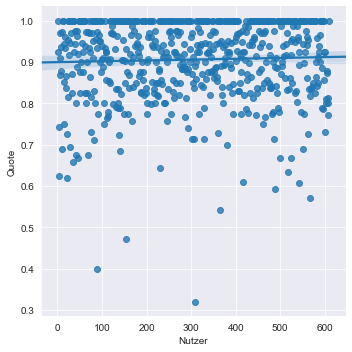

In [197]:
sns.lmplot(data=UebersichtNutzen1, x="Nutzer", y='Quote')

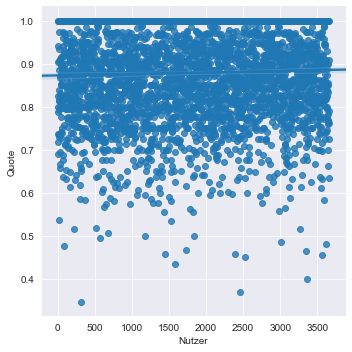

In [198]:
sns.lmplot(data=UebersichtProfitCutoff1, x="Nutzer", y='Quote')

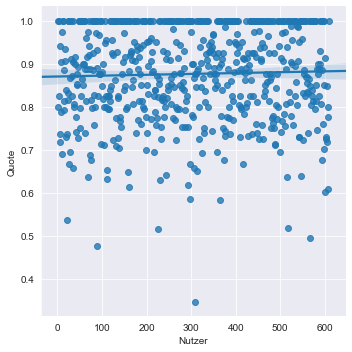

In [199]:
sns.lmplot(data=UebersichtProfit1, x="Nutzer", y='Quote')

In [200]:
vergl_df_m = vergl_df[['Nutzer', 'Profit Quote', 'Nutzen Quote']].melt('Nutzer', var_name='cols',  value_name='vals')
g = sns.lmplot(x="Nutzer", y="vals", hue='cols', data=vergl_df_m)

NameError: name 'vergl_df' is not defined